
# Organism identification using BLAST

The overall purpose for this notebook is to use some test DNA sequences (for example, for something you may have identified and sequences in the lab) to determine the best matches for what the organism may be, using BLAST.

This notebook is modified from a notebook made during one of NCBI's Hackathons located on GitHub [here]('https://github.com/NCBI-Hackathons/NCBI_Jupyter/blob/master/NoteBooks/Organism_identification_with_BLAST.ipynb')

We first need to install Biopython.  In this case we are using a Python 3.6 environment using an Anaconda distribution.  For regular python distributions, `pip install biopython` will work

In [1]:
#!conda install Biopython

Point to the fasta files you would like to test to identify organism.  In this example we will use files from [the GitHub repo]('https://github.com/NCBI-Hackathons/NCBI_Jupyter/tree/master/NoteBooks') where the original version of this notebook is.

In [2]:
import urllib
input_url = 'https://github.com/NCBI-Hackathons/NCBI_Jupyter/raw/master/NoteBooks/TestData/test_file.fasta' # If you want to use your own files, put the full URL of publicy accessible file here.
f = urllib.request.urlopen(input_url)
data = f.read()

# if you wanted to use your own file, you would specify the data in this manner
#input_path = 'path_to_file/test_file.fasta'
#f = open(input_path)

Run BLAST of your sequence against a suspected taxonomy branch (faster)

In [3]:
from Bio.Blast.NCBIWWW import qblast

Don't forget to change organism_subgroup accordingly, and don't leave it empty or too vague (like Bacteria), otherwise the BLAST will timeout if the amount of work is too high.

In our case, we will use 'entrez_query' with 'Staphylococcus aureus' (variable organism_subgroup) in organism to narrow down the search. It takes several minutes (10-15) to run one megabase query against it.

In [4]:
organism_subgroup = '"Staphylococcus aureus"[orgn]'
save_blast_run = False
blast_result = qblast('blastn', 'nr', data, entrez_query=organism_subgroup)

If you set save_blast_run to True, make sure that you have writeable directory and Test_sequences is in your Jupyther space, otherwise intermediate results can't be saved

In [5]:
blast_result_path = 'Test_sequences/blast.xml'
use_best_homogeneity_filter = True
save_blast_run = True

Preserve the XML results

In [6]:
if save_blast_run:
    res_str = blast_result.read()
    with open(blast_result_path,'w') as f:
        f.write(res_str)

Parse the results

In [7]:
from Bio.Blast import NCBIXML

Because we saved the result to file, we can try different procedures over it.

Here we write a function that finds the best hit for every sequence in the query (they are all in their own blast_records) and record the associatred id and organism. The organism with the best total score signifies the ogranism that most cloesly matches our query.

In [8]:
def best_organisms(result_handle, use_best_homogeneity_filter):
    seqs_to_total_best_bits = {}
    seqs_to_def = {}
    blast_records = NCBIXML.parse(result_handle)
    for blast_record in blast_records:
        best_bits = 0
        best_id = ""
        best_def = ""
        best_hits = []
        for aln in blast_record.alignments:
            # This is an alignment between blast_record.query_id and aln.hit_id
            total_bits = 0
            total_query_len = 0
            total_identity = 0
            for hsp in aln.hsps:
                if hsp.expect < E_VALUE_THRESH:
                    total_bits += hsp.bits
                    total_query_len += hsp.query_end - hsp.query_start + 1
                    total_identity  += hsp.identities
            if total_query_len == 0: continue
            best_hits.append((total_bits, total_identity/total_query_len, aln.hit_id, aln.hit_def))
            if total_bits > best_bits:
                best_bits = total_bits
                best_id   = aln.hit_id
                best_def  = aln.hit_def
        best_hits.sort(reverse=True)
        # Here we have all hits of a given contig, blast_record.query_id sorted in
        # best-first order
        # We can analyze if the several best hits are close to each other and thus
        # don't differentiate our organism well. We sort out such contigs.
        if use_best_homogeneity_filter:
            if len(best_hits) == 0: continue
            if len(best_hits) > 1:
                # if the first 2 hits are too close to each other and their identity score the same
                # throw the contig away
                if (best_hits[0][0]-best_hits[1][0])/best_hits[0][0] < 0.01 and \
                   (best_hits[0][1]-best_hits[1][1])/best_hits[0][1] < 0.01:
                    continue
                best_bits = best_hits[0][0]
                best_id   = best_hits[0][2]
                best_def  = best_hits[0][3]
        if best_id == "": continue
#        seqs_to_best_hits.setdefault(best_id, []).append(best_bits)
        seqs_to_def[best_id] = best_def
        seqs_to_total_best_bits[best_id] = seqs_to_total_best_bits.get(best_id, 0) + best_bits
    return seqs_to_total_best_bits, seqs_to_def


In [9]:
E_VALUE_THRESH = 0.04
# This dict maps sequence id to its best hits
seqs_to_total_best_bits = {}
seqs_to_def = {}
if save_blast_run: # we can just access our saved data on file
    with open(blast_result_path) as result_handle:
        seqs_to_total_best_bits, seqs_to_def = best_organisms(result_handle, use_best_homogeneity_filter)
else: # you must re-run the blast code cell each time you use the notebook if you do not save the outputs
    seqs_to_total_best_bits, seqs_to_def = best_organisms(blast_result, use_best_homogeneity_filter)


In [13]:
sorted_organisms = []
for k, bits in seqs_to_total_best_bits.items():
    sorted_organisms.append((bits, k))
sorted_organisms.sort(reverse=True)
top_k = 10
print('Best organisms are:')
for i in range(top_k):
    seq_id = sorted_organisms[i][1] # Best id
    print('#' + str(i + 1) + ': ' + seqs_to_def[seq_id] + ' with total score: ' + str(seqs_to_total_best_bits[seq_id]))

Best organisms are:
#1: Staphylococcus aureus strain UTSW MRSA 55 plasmid UTSW55_3, complete sequence with total score: 30321.7463
#2: Staphylococcus aureus subsp. aureus strain 1971.C01 plasmid p1971.C01c, complete sequence with total score: 20202.350500000004
#3: Staphylococcus aureus strain MOZ66 chromosome, complete genome with total score: 19208.393799999998
#4: Staphylococcus aureus strain FDAARGOS_1 chromosome, complete genome with total score: 19189.348099999996
#5: Staphylococcus aureus subsp. aureus strain 5118.N plasmid p5118.Nb, complete sequence with total score: 9322.128999999999
#6: Staphylococcus aureus strain NCTC5663 genome assembly, chromosome: 1 with total score: 8112.709600000002
#7: Staphylococcus aureus strain NCTC13395 genome assembly, chromosome: 1 with total score: 7953.312699999999
#8: Staphylococcus aureus strain AR_475 chromosome, complete genome with total score: 6569.266999999999
#9: Staphylococcus aureus strain FDAARGOS_504 chromosome, complete genome wi

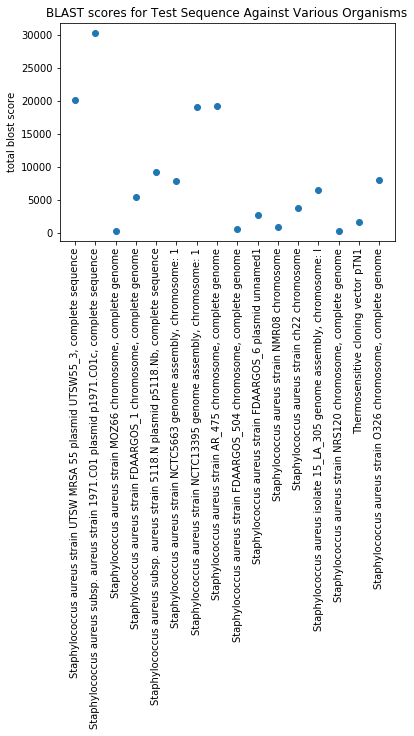

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# we collect the names of the sequences
names = []
for i in range(len(sorted_organisms)):
    names.append(seqs_to_def[sorted_organisms[i][1]])
plt.scatter(x=names, y=seqs_to_total_best_bits.values())
plt.ylabel('total blost score')
plt.title('BLAST scores for Test Sequence Against Various Organisms')
plt.xticks(rotation='vertical') # easy trick to hide the organism names
plt.show()